In [96]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from scipy.spatial.distance import cdist

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

# Data Cleaning 

## Missing Data 

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [13]:
data_filled = data.copy()

### MINIMUM_PAYMENTS 

In [9]:
data['MINIMUM_PAYMENTS'].isnull().sum()

313

MINIMUM_PAYMENTS missing 313 values

In [15]:
data_filled['MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].fillna(0)

### CREDIT_LIMIT 

In [ ]:
data_filled['CREDIT_LIMIT'] = data['CREDIT_LIMIT'].fillna(0)

Checking all values are filled :

In [17]:
data_filled.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Feature selection 

In [23]:
data_clean = data_filled.drop('CUST_ID', axis=1)

## Data Scaling 

In [26]:
data_scaled = preprocessing.scale(data_clean)

# Clustering 

## K-Means 

### Selecting number of clusters 

In [38]:
def plot_elbow(df):
    distorsions = []
    K = range(1, 10)
    for k in K:
        kmeans_model = KMeans(n_clusters=k).fit(df)
        distorsions.append(sum(np.min(cdist(df, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) 
                           / df.shape[0])
    plt.plot(K, distorsions, 'bx-')
    plt.xlabel('k'), plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

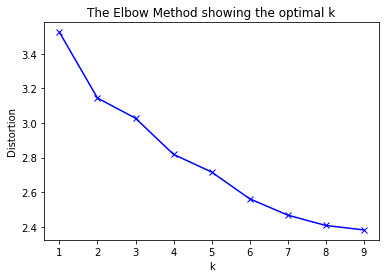

In [39]:
plot_elbow(data_scaled)

No obvious cluster number can be found from this graph

### Silhouette Scores 

In [45]:
def print_k_silhouette_scores(df, range_k_clusters, Algorithm):
    for k in range_k_clusters:
        clusterer = Algorithm(n_clusters = k)
        cluster_labels = clusterer.fit_predict(df)
        
        silhouette_avg = silhouette_score(df, cluster_labels)
        print(f"for {k} clusters, the average silhouette score is : {silhouette_avg}")


In [47]:
print_k_silhouette_scores(data_scaled, range(2,9), KMeans)

for 2 clusters, the average silhouette score is : 0.20968450812770809
for 3 clusters, the average silhouette score is : 0.25058607204185135
for 4 clusters, the average silhouette score is : 0.1976760935247528
for 5 clusters, the average silhouette score is : 0.19295124119495485
for 6 clusters, the average silhouette score is : 0.2028458684661232
for 7 clusters, the average silhouette score is : 0.2154020562158529
for 8 clusters, the average silhouette score is : 0.22176335695372815


Best silhouette score for 3 clusters

### Cluster distribution

In [67]:
def plot_distribution(labels):
    '''Input: numpy array of the cluster assigned to each individual
    This function displays a cluster distribution bar plot'''
    clusters, counts = np.unique(labels, return_counts=True)
    plt.bar(clusters, counts)
    plt.title('Cluster distribution')
    plt.xlabel('Cluster label')
    plt.ylabel('Number of individuals')
    plt.show

In [77]:
kmeans_model = KMeans(n_clusters=3).fit(data_scaled)
plot_distribution(kmeans_model.labels_)

### Cluster visualization

In [78]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(data_scaled)
reduced = pd.DataFrame(tsne_results, columns=['axis1', 'axis2'])

In [83]:
def cluster_visualization(labels):
    """
    Input : a list of label defined by the clustering algorithm 
    Output : data visualization of the clusters in 2D
    """
    label_df = pd.DataFrame(labels, columns=['label'])
    visualization = reduced.join(label_df, how='inner')
    
    visualization.plot.scatter(x='axis1', y='axis2', c='label', colormap='viridis')
    plt.show()

In [84]:
cluster_visualization(kmeans_model.labels_)

## Gaussian Mixture Model 

### Selecting number of clusters 

In [88]:
range_n_clusters = range(2,10)
for n in range_n_clusters:
        clusterer = GaussianMixture(n_components=n)
        cluster_labels = clusterer.fit_predict(data_scaled)
        
        silhouette_avg = silhouette_score(data_scaled, cluster_labels)
        print(f"for {n} clusters, the average silhouette score is : {silhouette_avg}")


for 2 clusters, the average silhouette score is : 0.1844687167682946
for 3 clusters, the average silhouette score is : 0.11248495419356612
for 4 clusters, the average silhouette score is : 0.09739948921343268
for 5 clusters, the average silhouette score is : 0.06420764223496761
for 6 clusters, the average silhouette score is : 0.05179732971646683
for 7 clusters, the average silhouette score is : 0.04656570913040829
for 8 clusters, the average silhouette score is : 0.026735375603460974
for 9 clusters, the average silhouette score is : 0.01789740061828711


The more clusters, the worst the silhouette score is.  
We'll choose 3 clusters.

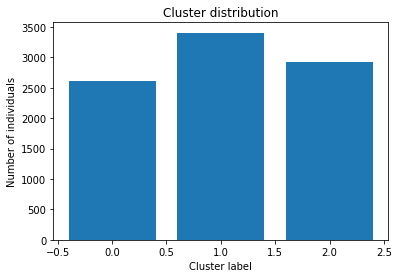

In [92]:
gmm_model = GaussianMixture(n_components=3).fit(data_scaled)
gmm_labels = gmm_model.predict(data_scaled)
plot_distribution(gmm_labels)

### Cluster Visualization 

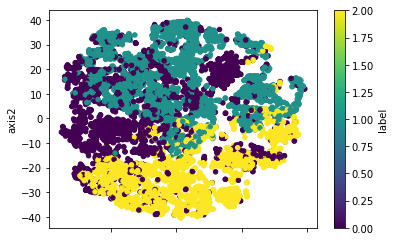

In [93]:
cluster_visualization(gmm_labels)

## DBSCAN

###  Finding the optimal Epsilon

In [108]:
def plot_epsilon_distance(df, n_neighbors):
    """
    Input : dataframe with scaled numeric values and number of neighbors to consider in int format
    Output : plot of distance between the nearest neighbors
    """
    nNeighbors = NearestNeighbors(n_neighbors)
    nbrs = nNeighbors.fit(df)
    
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.show()

In [109]:
plot_epsilon_distance(data_scaled, 2)

According to the graph, we should choose an epsilon of 8.3 for the DBSCAN model.  
However this value generates only 1 cluster. We will lower it to 5.

In [157]:
dbscan_model = DBSCAN(eps=5, min_samples=5).fit(data_scaled)
dbscan_labels = dbscan_model.labels_
n_clusters  = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'Estimated number of cluters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')
print("Silhouette Coefficient: {}".format(silhouette_score(data_scaled, dbscan_labels)))
plot_distribution(dbscan_labels)

Estimated number of cluters: 2
Estimated number of noise points: 55
Silhouette Coefficient: 0.7123129555777675


Very poor distribution among cluters.

### Cluster visualization 

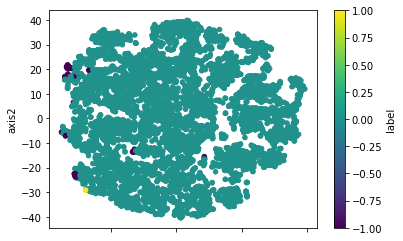

In [143]:
cluster_visualization(dbscan_labels)

## Agglomerative clustering 

In [146]:
print_k_silhouette_scores(data_scaled, range(2,10), AgglomerativeClustering)

for 2 clusters, the average silhouette score is : 0.18825730625543027
for 3 clusters, the average silhouette score is : 0.17592811196748037
for 4 clusters, the average silhouette score is : 0.17750219678235557
for 5 clusters, the average silhouette score is : 0.13852656621225568
for 6 clusters, the average silhouette score is : 0.12618056872422692
for 7 clusters, the average silhouette score is : 0.15280970012444745
for 8 clusters, the average silhouette score is : 0.1502448666551726
for 9 clusters, the average silhouette score is : 0.16115260314329874


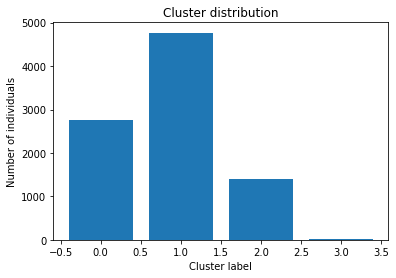

In [147]:
agglomerative_model = AgglomerativeClustering(n_clusters=4)
agglomerative_labels = agglomerative_model.fit_predict(data_scaled)

plot_distribution(agglomerative_labels)

### Cluter Visualization 

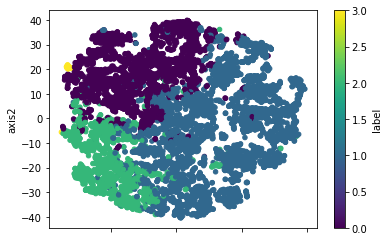

In [148]:
cluster_visualization(agglomerative_labels)